In [1]:
import os
import math
import random
import numpy as np

# Import the SyntheticData class from factor_eval.py
# Ensure factor_eval.py is in the same directory as your notebook
from factor_eval import SyntheticData

# Set the random seed for reproducibility
seed = 42
random.seed(seed)
np.random.seed(seed)

# Generate synthetic data with the same specifications as before
# - 50,000 training samples, 12,500 test samples
# - 5 latent factors, k=10 => 50 observed variables
# - SNR = 0.5, no correlation, no nuisance
# - Fixed seed for reproducibility
synthetic_data = SyntheticData(
    n_samples=50000,
    n_test=12500,
    n_sources=5,
    k=30,
    snr=2,             # Lower SNR to increase noise
    correlate_sources=0.6,# Introduce correlation among latent factors
    get_covariance=False,
    random_scale=True,    # Randomly scale variables for additional complexity
    nuisance=0,           # No nuisance variables
    seed=42               # Fixed seed for reproducibility
)


# Extract training and test sets as NumPy arrays
X_train = synthetic_data.train
X_test = synthetic_data.test

# Display shapes and verify
print("Training set shape:", X_train.shape)  # Expected (50000, 50)
print("Test set shape:", X_test.shape)      # Expected (12500, 50)

Training set shape: (50000, 150)
Test set shape: (12500, 150)


In [2]:
from sklearn.decomposition import FactorAnalysis
from sklearn.metrics import mean_squared_error

# Define the FA model with the number of components matching your latent dimension
n_components = 5  # Use your desired number of factors

fa = FactorAnalysis(n_components=n_components, random_state=42)

# Fit FA on the training data
fa.fit(X_train)

# Transform the training data to get the latent factors
X_train_reduced_fa = fa.transform(X_train)

# Manually reconstruct the training data using the latent factors and the factor loadings
X_train_reconstructed_fa = np.dot(X_train_reduced_fa, fa.components_) + np.mean(X_train, axis=0)

# Calculate the MSE on the training set
mse_train_fa = mean_squared_error(X_train, X_train_reconstructed_fa)
print(f"\nFA MSE on training set: {mse_train_fa:.6f}")

# Transform the test data using the trained FA model
X_test_reduced_fa = fa.transform(X_test)

# Reconstruct the test data using the latent factors and the factor loadings
X_test_reconstructed_fa = np.dot(X_test_reduced_fa, fa.components_) + np.mean(X_train, axis=0)  # Use train mean for consistent reconstruction

# Calculate the MSE on the test set
mse_test_fa = mean_squared_error(X_test, X_test_reconstructed_fa)
print(f"FA MSE on test set: {mse_test_fa:.6f}")


FA MSE on training set: 0.783321
FA MSE on test set: 0.781033


In [3]:
from sklearn.metrics import adjusted_rand_score

# Get factor loadings
factor_loadings = fa.components_.T  # (n_features, n_components)
predicted_variable_labels = np.argmax(np.abs(factor_loadings), axis=1)

# true_labels comes directly from synthetic_data
true_labels = np.array(synthetic_data.clusters, dtype=int)

# Filter out nuisance (-1) if present for ARI calculation
mask = (true_labels != -1)
filtered_true = true_labels[mask]
filtered_pred = predicted_variable_labels[mask]

# If there are no non-nuisance variables (filtered_true is empty),
# we define ARI as 1.0 by convention, as there's nothing to cluster.
# Otherwise, compute ARI normally.
if len(filtered_true) == 0:
    # No non-nuisance variables, so ARI doesn't make sense. Default to 1.0.
    ari_fa = 1.0
else:
    # Compute ARI on the filtered sets (no nuisance variables included)
    ari_fa = adjusted_rand_score(filtered_true, filtered_pred)

print(f"\nFA Adjusted Rand Index (ARI) on variables: {ari_fa:.4f}")


FA Adjusted Rand Index (ARI) on variables: 0.4791


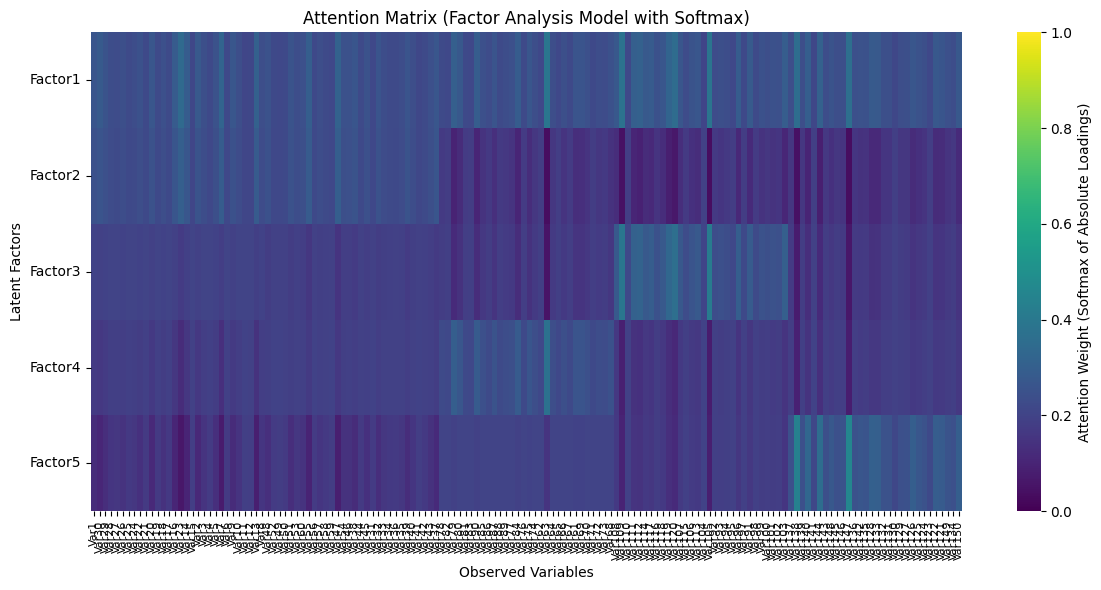

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

abs_factor_loadings = np.abs(factor_loadings)

def softmax(x):
    e_x = np.exp(x - np.max(x, axis=1, keepdims=True))
    return e_x / np.sum(e_x, axis=1, keepdims=True)

softmax_loadings = softmax(abs_factor_loadings)  # (n_features, n_components)

# Use synthetic_data.clusters to order variables by their assigned cluster
clusters = np.array(synthetic_data.clusters, dtype=int)

if np.any(clusters == -1):
    # If nuisance variables are present, separate them out:
    non_nuisance_indices = np.where(clusters != -1)[0]
    nuisance_indices = np.where(clusters == -1)[0]
    # Sort non-nuisance variables by their cluster labels
    sorted_non_nuisance = non_nuisance_indices[np.argsort(clusters[non_nuisance_indices])]
    # Concatenate the sorted non-nuisance variables followed by nuisance variables at the end
    new_order = np.concatenate([sorted_non_nuisance, nuisance_indices])
else:
    # If no nuisance variables are present, proceed as before:
    new_order = np.argsort(clusters)

softmax_loadings_reordered = softmax_loadings[new_order, :]
attention_matrix = softmax_loadings_reordered.T

# Define input_dim and output_dim if not defined yet
input_dim = synthetic_data.train.shape[1]
output_dim = synthetic_data.n_sources

factor_names = [f"Factor{i+1}" for i in range(output_dim)]
variable_labels = [f"Var{i+1}" for i in range(input_dim)]

def plot_attention_heatmap(attn_matrix, title, factor_names, variable_labels):
    plt.figure(figsize=(12, 6))
    sns.heatmap(
        attn_matrix,
        cmap='viridis',
        vmin=0,
        vmax=1,
        cbar_kws={'label': 'Attention Weight (Softmax of Absolute Loadings)'}
    )
    plt.title(title)
    plt.xlabel('Observed Variables')
    plt.ylabel('Latent Factors')
    plt.xticks(
        ticks=np.arange(len(variable_labels))+0.5, 
        labels=np.array(variable_labels)[new_order], 
        rotation=90, 
        fontsize=8
    )
    plt.yticks(
        ticks=np.arange(len(factor_names))+0.5, 
        labels=factor_names, 
        rotation=0
    )
    plt.tight_layout()
    plt.show()

plot_attention_heatmap(
    attn_matrix=attention_matrix,
    title='Attention Matrix (Factor Analysis Model with Softmax)',
    factor_names=factor_names,
    variable_labels=variable_labels
)